In [10]:
# Import required libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import os

In [11]:
# Interpolated Rotary Positional Embedding and Helper Functions
class InterpolatedRotaryEmbedding(nn.Module):
    """Implements Interpolated Rotary Positional Embedding (RoPE) with interpolation for longer sequences."""
    def __init__(self, dim, max_seq_len, original_seq_len):
        super().__init__()
        self.original_seq_len = original_seq_len
        self.max_seq_len = max_seq_len
        # Interpolated RoPE scales down the frequencies for longer sequences
        # This allows the model to handle sequences longer than the original training sequences
        self.scale = original_seq_len / max_seq_len
        
        # Original frequency computation as in standard RoPE
        inv_freq = 1.0 / (10000 ** (torch.arange(0, dim, 2).float() / dim))
        self.register_buffer('inv_freq', inv_freq)
    
    def forward(self, seq_len, device):
        """
        Generates interpolated sinusoidal embeddings for Interpolated RoPE.

        Args:
            seq_len (int): The length of the sequence.
            device (torch.device): The device to create tensors on.

        Returns:
            torch.Tensor: Sinusoidal embeddings of shape (seq_len, dim).
        """
        # In Interpolated RoPE, frequencies are scaled
        # This scaling allows the embeddings to adapt to different sequence lengths
        scaled_freq = self.inv_freq * self.scale

        # Generate positions (no scaling needed here, same as in standard RoPE)
        t = torch.arange(seq_len, device=device).type_as(scaled_freq)
        
        # Apply scaled frequencies to positions (outer product)
        freqs = torch.einsum('i , j -> i j', t, scaled_freq)
        
        # Combine sin and cos embeddings
        emb = torch.cat((freqs, freqs), dim=-1)
        return emb  # (seq_len, dim)

def rotate_half(x):
    """Helper function for rotating half of the dimensions"""
    x1, x2 = x.chunk(2, dim=-1)
    return torch.cat((-x2, x1), dim=-1)

def apply_rotary_pos_emb(q, k, sinusoidal_pos):
    """
    Applies RoPE to query and key tensors.

    Args:
        q (torch.Tensor): Query tensor of shape (batch_size, num_heads, seq_len, head_dim).
        k (torch.Tensor): Key tensor of shape (batch_size, num_heads, seq_len, head_dim).
        sinusoidal_pos (torch.Tensor): Sinusoidal embeddings of shape (seq_len, head_dim).

    Returns:
        Tuple[torch.Tensor, torch.Tensor]: Rotated query and key tensors.
    """
    sin, cos = sinusoidal_pos.sin(), sinusoidal_pos.cos()
    sin = sin.unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, seq_len, head_dim)
    cos = cos.unsqueeze(0).unsqueeze(0)
    q_rot = (q * cos) + (rotate_half(q) * sin)
    k_rot = (k * cos) + (rotate_half(k) * sin)
    return q_rot, k_rot

# Neural network components

class FeedForwardNetwork(nn.Module):
    """Simple feed-forward network to project input features"""
    def __init__(self, d_in, d_model):
        super().__init__()
        self.mlp = nn.Linear(d_in, d_model)
    
    def forward(self, x):
        return self.mlp(x)

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention mechanism with Interpolated RoPE"""
    def __init__(self, d_model, num_heads, max_seq_len, original_seq_len):
        super().__init__()
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        assert self.head_dim * num_heads == d_model, "d_model must be divisible by num_heads"

        self.qkv_proj = nn.Linear(d_model, 3 * d_model)
        self.out_proj = nn.Linear(d_model, d_model)

        # Use Interpolated Rotary Embedding
        self.rotary_emb = InterpolatedRotaryEmbedding(self.head_dim, max_seq_len, original_seq_len)

    def forward(self, x, key_padding_mask=None):
        """
        Performs the forward pass of the multi-head attention with Interpolated RoPE.

        Args:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, d_model).
            key_padding_mask (torch.Tensor, optional): Padding mask of shape (batch_size, seq_len).

        Returns:
            torch.Tensor: Output tensor of shape (seq_len, batch_size, d_model).
        """
        seq_len, batch_size, _ = x.size()

        # Project to query, key, value
        qkv = self.qkv_proj(x)  # Shape: (seq_len, batch_size, 3*d_model)
        qkv = qkv.view(seq_len, batch_size, 3, self.num_heads, self.head_dim)
        qkv = qkv.permute(2, 1, 3, 0, 4)  # Shape: (3, batch_size, num_heads, seq_len, head_dim)
        q, k, v = qkv[0], qkv[1], qkv[2]  # Each shape: (batch_size, num_heads, seq_len, head_dim)

        # Generate sinusoidal positional embeddings
        sinusoidal_pos = self.rotary_emb(seq_len, device=x.device)  # Shape: (seq_len, head_dim)

        # Apply Interpolated RoPE to q and k
        q, k = apply_rotary_pos_emb(q, k, sinusoidal_pos)

        # Compute scaled dot-product attention
        attn_scores = torch.einsum('bnqd, bnkd -> bnqk', q, k)  # Shape: (batch_size, num_heads, seq_len, seq_len)
        attn_scores = attn_scores / (self.head_dim ** 0.5)

        if key_padding_mask is not None:
            # key_padding_mask: (batch_size, seq_len)
            attn_scores = attn_scores.masked_fill(key_padding_mask.unsqueeze(1).unsqueeze(2), float('-inf'))

        attn_probs = F.softmax(attn_scores, dim=-1)  # Shape: (batch_size, num_heads, seq_len, seq_len)

        attn_output = torch.einsum('bnqk, bnkd -> bnqd', attn_probs, v)  # Shape: (batch_size, num_heads, seq_len, head_dim)

        # Concatenate heads
        attn_output = attn_output.permute(2, 0, 1, 3).contiguous()  # Shape: (seq_len, batch_size, num_heads, head_dim)
        attn_output = attn_output.view(seq_len, batch_size, self.d_model)  # Shape: (seq_len, batch_size, d_model)

        # Final linear projection
        output = self.out_proj(attn_output)  # Shape: (seq_len, batch_size, d_model)

        return output


class EncoderLayer(nn.Module):
    """Transformer encoder layer with self-attention and feed-forward network"""
    def __init__(self, d_model, num_heads, d_ff, max_seq_len, original_seq_len):
        super().__init__()
        self.mha = MultiHeadAttention(d_model, num_heads, max_seq_len, original_seq_len)
        self.ff = nn.Sequential(
            nn.Linear(d_model, d_ff),
            nn.ReLU(),
            nn.Linear(d_ff, d_model)
        )
        self.norm1 = nn.LayerNorm(d_model)
        self.norm2 = nn.LayerNorm(d_model)

    def forward(self, x, src_key_padding_mask=None):
        """
        Performs the forward pass of the encoder layer.

        Args:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, d_model).
            src_key_padding_mask (torch.Tensor, optional): Padding mask.

        Returns:
            torch.Tensor: Output tensor of the same shape as input.
        """
        # Multi-head attention with residual connection and layer normalization
        attn_output = self.mha(x, key_padding_mask=src_key_padding_mask)
        x = self.norm1(x + attn_output)
        # Feed-forward network with residual connection and layer normalization
        ff_output = self.ff(x)
        x = self.norm2(x + ff_output)
        return x

class Encoder(nn.Module):
    """Stack of transformer encoder layers"""
    def __init__(self, d_model, num_heads, d_ff, num_layers, max_seq_len, original_seq_len):
        super().__init__()
        self.layers = nn.ModuleList([EncoderLayer(d_model, num_heads, d_ff, max_seq_len, original_seq_len) for _ in range(num_layers)])

    def forward(self, x, src_key_padding_mask=None):
        """
        Passes the input through the stack of encoder layers.

        Args:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, d_model).
            src_key_padding_mask (torch.Tensor, optional): Padding mask.

        Returns:
            torch.Tensor: Output tensor of shape (seq_len, batch_size, d_model).
        """
        for layer in self.layers:
            x = layer(x, src_key_padding_mask)
        return x

class Decoder(nn.Module):
    """Simple linear decoder to project back to output dimension"""
    def __init__(self, d_model, d_out):
        super().__init__()
        self.linear = nn.Linear(d_model, d_out)

    def forward(self, x):
        """
        Projects the encoder output to the desired output dimension.

        Args:
            x (torch.Tensor): Input tensor of shape (seq_len, batch_size, d_model).

        Returns:
            torch.Tensor: Output tensor of shape (seq_len, batch_size, d_out).
        """
        return self.linear(x)

class Astromer(nn.Module):
    """Main model architecture for light curve processing"""
    def __init__(self, d_model, num_heads, d_ff, num_layers, max_seq_len, original_seq_len):
        super().__init__()
        self.d_model = d_model
        self.fnn = FeedForwardNetwork(1, d_model)
        self.encoder = Encoder(d_model, num_heads, d_ff, num_layers, max_seq_len, original_seq_len)
        self.decoder = Decoder(d_model, 1)

    def forward(self, times, magnitudes, lengths, mask_prob=0.15):
        """
        Processes the input light curves and reconstructs the magnitudes.

        Args:
            times (torch.Tensor): Time steps tensor of shape (batch_size, seq_len).
            magnitudes (torch.Tensor): Magnitudes tensor of shape (batch_size, seq_len).
            lengths (torch.Tensor): Actual lengths of each sequence in the batch.
            mask_prob (float): Probability of masking an input magnitude.

        Returns:
            torch.Tensor: Reconstructed magnitudes of shape (batch_size, seq_len).
        """
        batch_size, seq_len = magnitudes.size()

        # Normalize time steps
        times = self.normalize_times(times, lengths)

        # Apply masking and initial feature projection
        masked_magnitudes = self.mask_magnitudes(magnitudes, lengths, mask_prob)
        x = self.fnn(masked_magnitudes.unsqueeze(-1))  # Shape: (batch_size, seq_len, d_model)

        # Prepare input for transformer: transpose to (seq_len, batch_size, d_model)
        x = x.transpose(0, 1)

        # Create attention padding mask
        padding_mask = self.create_padding_mask(lengths, seq_len)  # Shape: (batch_size, seq_len)

        # Process through encoder
        encoded = self.encoder(x, src_key_padding_mask=padding_mask)

        # Decode to final predictions
        decoded = self.decoder(encoded)  # Shape: (seq_len, batch_size, 1)
        reconstructed = decoded.squeeze(-1).transpose(0, 1)  # Shape: (batch_size, seq_len)

        return reconstructed

    def normalize_times(self, times, lengths):
        """
        Normalizes time steps within each sequence to the range [0, 1].

        Args:
            times (torch.Tensor): Time steps tensor of shape (batch_size, seq_len).
            lengths (torch.Tensor): Actual lengths of each sequence.

        Returns:
            torch.Tensor: Normalized time steps tensor.
        """
        batch_size, seq_len = times.size()
        times_normalized = times.clone()
        for i in range(batch_size):
            length = lengths[i]
            seq_times = times[i, :length]
            min_t = seq_times.min()
            max_t = seq_times.max()
            if max_t > min_t:
                times_normalized[i, :length] = (seq_times - min_t) / (max_t - min_t)
            else:
                times_normalized[i, :length] = 0.0  # All times are the same
        return times_normalized

    def mask_magnitudes(self, magnitudes, lengths, mask_prob):
        """
        Randomly masks input magnitudes for denoising training.

        Args:
            magnitudes (torch.Tensor): Magnitudes tensor of shape (batch_size, seq_len).
            lengths (torch.Tensor): Actual lengths of each sequence.
            mask_prob (float): Probability of masking an input magnitude.

        Returns:
            torch.Tensor: Masked magnitudes tensor.
        """
        batch_size, seq_len = magnitudes.size()
        # Create a mask for valid positions
        valid_mask = torch.arange(seq_len, device=lengths.device).unsqueeze(0) < lengths.unsqueeze(1)
        # Create random mask for masking magnitudes
        random_mask = (torch.rand(batch_size, seq_len, device=magnitudes.device) < mask_prob) & valid_mask
        masked_magnitudes = magnitudes.clone()
        masked_magnitudes[random_mask] = 0.0
        return masked_magnitudes

    def create_padding_mask(self, lengths, max_length):
        """
        Creates mask for padding tokens in attention mechanism.

        Args:
            lengths (torch.Tensor): Actual lengths of each sequence.
            max_length (int): Maximum sequence length in the batch.

        Returns:
            torch.Tensor: Padding mask of shape (batch_size, seq_len).
        """
        # Mask positions that are padding (True for padding positions)
        padding_mask = torch.arange(max_length, device=lengths.device).unsqueeze(0) >= lengths.unsqueeze(1)
        return padding_mask  # Shape: (batch_size, seq_len)

In [12]:
# Dataset class setup
class LightCurveDataset(Dataset):
    """Dataset class for light curve data with padding"""
    def __init__(self, times, magnitudes, max_length):
        self.times = times
        self.magnitudes = magnitudes
        self.max_length = max_length

    def __len__(self):
        return len(self.times)

    def __getitem__(self, idx):
        time = self.times[idx]
        magnitude = self.magnitudes[idx]
        length = len(time)

        # Pad sequences to max_length
        padded_time = torch.zeros(self.max_length)
        padded_magnitude = torch.zeros(self.max_length)
        
        padded_time[:length] = torch.tensor(time, dtype=torch.float32)
        padded_magnitude[:length] = torch.tensor(magnitude, dtype=torch.float32)
        
        return padded_time, padded_magnitude, length


In [13]:
# Model configuration
d_model = 128
num_heads = 4
d_ff = 256
num_layers = 3
max_seq_len = 100
original_seq_len = 50

# Initialize model and optimizer
model = Astromer(
    d_model=d_model,
    num_heads=num_heads,
    d_ff=d_ff,
    num_layers=num_layers,
    max_seq_len=max_seq_len,
    original_seq_len=original_seq_len
)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [14]:
model

Astromer(
  (fnn): FeedForwardNetwork(
    (mlp): Linear(in_features=1, out_features=128, bias=True)
  )
  (encoder): Encoder(
    (layers): ModuleList(
      (0-2): 3 x EncoderLayer(
        (mha): MultiHeadAttention(
          (qkv_proj): Linear(in_features=128, out_features=384, bias=True)
          (out_proj): Linear(in_features=128, out_features=128, bias=True)
          (rotary_emb): InterpolatedRotaryEmbedding()
        )
        (ff): Sequential(
          (0): Linear(in_features=128, out_features=256, bias=True)
          (1): ReLU()
          (2): Linear(in_features=256, out_features=128, bias=True)
        )
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
      )
    )
  )
  (decoder): Decoder(
    (linear): Linear(in_features=128, out_features=1, bias=True)
  )
)

In [20]:
# Data preparation
file_path = '../Data/synthetic_light_curves.csv'
df = pd.read_csv(file_path)

# Convert all odd sample_ids to sample_id - 1
df['sample_id'] = df['sample_id'].apply(lambda x: x - 1 if x % 2 != 0 else x)

grouped = df.groupby('sample_id')

# Extract time series data
times = [group['time_mjd'].values for _, group in grouped]
magnitudes = [group['magnitude'].values for _, group in grouped]
max_length = max(len(t) for t in times)

# Split into train and test sets
train_times, test_times, train_mags, test_mags = train_test_split(
    times, magnitudes, test_size=0.2, random_state=42
)

# Create data loaders
train_dataset = LightCurveDataset(train_times, train_mags, max_length)
test_dataset = LightCurveDataset(test_times, test_mags, max_length)
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
df

In [21]:
# Training function
def train(model, optimizer, train_loader, test_loader, num_epochs=10):
    """Training loop with validation"""
    criterion = nn.MSELoss(reduction='none')
    best_test_loss = float('inf')
    model_dir = '../Models'
    os.makedirs(model_dir, exist_ok=True)
    best_model_path = os.path.join(model_dir, 'interpolated-rope-astromer.pth')
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        train_loss = 0.0
        for times, magnitudes, lengths in train_loader:
            optimizer.zero_grad()
            reconstructed = model(times, magnitudes, lengths)
            loss = criterion(reconstructed, magnitudes)
            # Apply mask to compute loss only on valid timesteps
            mask = torch.arange(magnitudes.size(1)).expand(magnitudes.size(0), magnitudes.size(1)) < lengths.unsqueeze(1)
            loss = (loss * mask.float()).sum() / mask.sum()
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        
        # Validation phase
        model.eval()
        test_loss = 0.0
        with torch.no_grad():
            for times, magnitudes, lengths in test_loader:
                reconstructed = model(times, magnitudes, lengths)
                loss = criterion(reconstructed, magnitudes)
                mask = torch.arange(magnitudes.size(1)).expand(magnitudes.size(0), magnitudes.size(1)) < lengths.unsqueeze(1)
                loss = (loss * mask.float()).sum() / mask.sum()
                test_loss += loss.item()
        
        test_loss /= len(test_loader)
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
        
        # Save best model
        if test_loss < best_test_loss:
            best_test_loss = test_loss
            torch.save(model.state_dict(), best_model_path)
            print(f"New best model saved to {best_model_path}")
    
    print(f"Training completed. Best model saved with test loss: {best_test_loss:.4f}")

In [22]:
# Start training
train(model, optimizer, train_loader, test_loader, num_epochs=10)

Epoch 1/10, Train Loss: 0.0515, Test Loss: 0.0535
New best model saved to ../Models/interpolated-rope-astromer.pth
Epoch 2/10, Train Loss: 0.0504, Test Loss: 0.0512
New best model saved to ../Models/interpolated-rope-astromer.pth
Epoch 3/10, Train Loss: 0.0497, Test Loss: 0.0470
New best model saved to ../Models/interpolated-rope-astromer.pth
Epoch 4/10, Train Loss: 0.0485, Test Loss: 0.0484
Epoch 5/10, Train Loss: 0.0480, Test Loss: 0.0470
New best model saved to ../Models/interpolated-rope-astromer.pth
Epoch 6/10, Train Loss: 0.0480, Test Loss: 0.0435
New best model saved to ../Models/interpolated-rope-astromer.pth
Epoch 7/10, Train Loss: 0.0475, Test Loss: 0.0414
New best model saved to ../Models/interpolated-rope-astromer.pth
Epoch 8/10, Train Loss: 0.0455, Test Loss: 0.0443
Epoch 9/10, Train Loss: 0.0447, Test Loss: 0.0495
Epoch 10/10, Train Loss: 0.0452, Test Loss: 0.0445
Training completed. Best model saved with test loss: 0.0414


Average inference time per sample: 59.30 ms
95.0% CI: [8.55, 66.00] ms


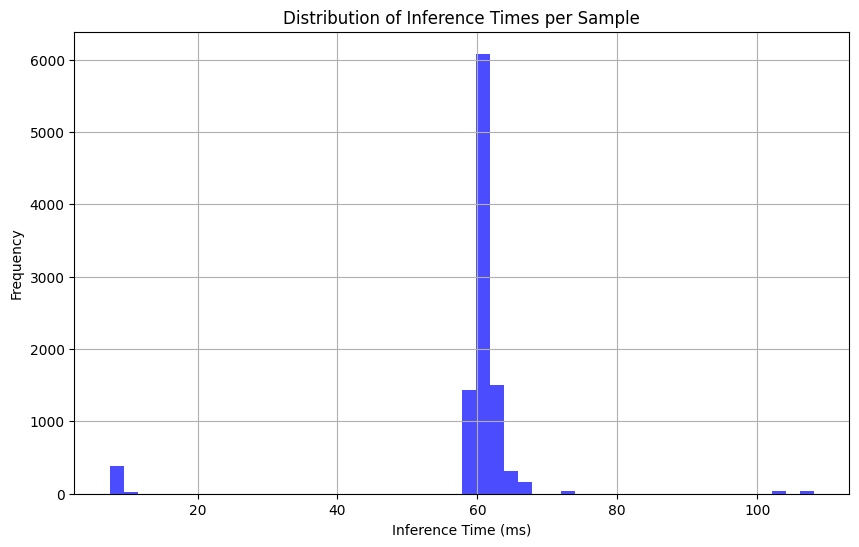

In [25]:
# Test inference time and plot distribution
import time
import numpy as np
import matplotlib.pyplot as plt

def test_inference_time(model, test_loader, num_runs=100, confidence_level=0.95):
    """
    Measure the average inference time per sample for a given model and plot the distribution of times.

    Args:
        model: The neural network model to test.
        test_loader: DataLoader containing the test dataset.
        num_runs (int): Number of inference runs to average over (default: 100).
        confidence_level (float): Confidence level for interval calculation (default: 0.95).
    """
    # Set model to evaluation mode
    model.eval()
    # Get the device (CPU or GPU) that the model is on
    device = next(model.parameters()).device
    total_time = 0
    total_samples = 0
    all_times = []
    
    with torch.no_grad():  # Disable gradient computation for inference
        for times, magnitudes, lengths in test_loader:
            # Move input data to the same device as the model
            times, magnitudes, lengths = times.to(device), magnitudes.to(device), lengths.to(device)
            batch_size = times.size(0)
            
            # Perform a warm-up run to ensure GPU is ready
            _ = model(times, magnitudes, lengths)
            
            # Timed runs
            batch_times = []
            for _ in range(num_runs):
                start_time = time.time()
                _ = model(times, magnitudes, lengths)
                end_time = time.time()
                batch_times.extend([end_time - start_time] * batch_size)
            
            all_times.extend(batch_times)
            total_time += sum(batch_times)
            total_samples += batch_size * num_runs
    
    # Calculate overall average inference time per sample
    avg_inference_time = total_time / total_samples
    
    # Calculate confidence interval
    alpha = 1 - confidence_level
    times_array = np.array(all_times)
    ci_lower = np.percentile(times_array, alpha * 100 / 2)
    ci_upper = np.percentile(times_array, 100 - (alpha * 100 / 2))
    
    print(f"Average inference time per sample: {avg_inference_time*1000:.2f} ms")
    print(f"{confidence_level*100:.1f}% CI: [{ci_lower*1000:.2f}, {ci_upper*1000:.2f}] ms")
    
    # Plot the distribution of inference times
    plt.figure(figsize=(10, 6))
    plt.hist(times_array * 1000, bins=50, color='blue', alpha=0.7)
    plt.title('Distribution of Inference Times per Sample')
    plt.xlabel('Inference Time (ms)')
    plt.ylabel('Frequency')
    plt.grid(True)
    plt.show()

# Test inference time using the trained model and test data loader
test_inference_time(model, test_loader)